In [1]:
import os, sys, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.utils.data as data

import torchvision
from torchvision import transforms

In [3]:
pascal_object_categories = ['__bgr__', 'aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

pascal_voc_classes_names = dict(zip(range(len(pascal_object_categories)), pascal_object_categories))
pascal_voc_classes = dict(zip(pascal_object_categories, range(len(pascal_object_categories))))

print("A total of {0:} classes".format(len(pascal_voc_classes)-1))

A total of 20 classes


In [4]:
pascal_voc_classes

{'__bgr__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [7]:
target_classes = {
    '__bgr__': 0,
    'person': 1,
    'car': 2
}

In [30]:
class PascalVocInterface(data.Dataset):
    
    def __init__(self, root_path, train_img_path, annotation_path, classes, target_classes):
        self.root_path = root_path
        self.data_path = os.path.join(self.root_path, train_img_path)
        self.labels_path = os.path.join(self.root_path, annotation_path)
        self.classes = classes
        self.target_classes = target_classes
        #self.imgs = os.listdir(self.data_path)
        self.imgs = self.get_annotations()
        
    def transform_img(self, img):
        trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.407, 0.457, 0.485],
                                 std=[0.229,0.224,0.225]),
        ])
        
        img = trans(img)
        return img
    
    def load_img(self, idx):
        img = Image.open(os.path.join(self.data_path, self.imgs[idx]))
        img = self.transform_img(img)
        return img
    
    def get_annotations(self):
        annotations = os.listdir(self.labels_path)
        imgs = []
        for ann in annotations: 
            tree = ET.parse(os.path.join(self.labels_path, ann))
            root = tree.getroot()
            classes = []
            bboxes = []
            dims = ['xmin', 'ymin', 'xmax', 'ymax']
            for obj in root.iter('object'):
                obj_name = obj.find('name').text
                if obj_name in self.target_classes.keys():
                    imgs.append(ann.split('.')[0] + '.jpg')
        return imgs
    
    def get_bbox(self, idx):
        fileName = self.imgs[idx].split('.')[0] + '.xml'
        #print(fileName)
        tree = ET.parse(os.path.join(self.labels_path, fileName))
        root = tree.getroot()
        classes = []
        bboxes = []
        dims = ['xmin', 'ymin', 'xmax', 'ymax']
        for obj in root.iter('object'):
            obj_name = obj.find('name').text
            if obj_name in self.target_classes.keys():
                #print(obj_name)
                bbox_dim = []
                classes.append(self.target_classes[obj_name])
                bbox = obj.find('bndbox')
                #print(bbox)
                for dim in dims:
                    bbox_dim.append(float(bbox.find(dim).text))
                #print(bbox_dim)
                bboxes.append(bbox_dim)

        label = {}
        #print(classes)
        #print(bboxes)        
        label['labels'] = torch.as_tensor(classes, dtype=torch.int64)
        label['boxes'] = torch.as_tensor(bboxes)
        return label
    
    def get_iou(self, bbox1, bbox2, img_size):
        #print(bbox1, bbox2)
        mask = np.zeros(img_size)
        mask[int(bbox1[0]):int(bbox1[2]), int(bbox1[1]):int(bbox1[3])] += 1
        mask[int(bbox2[0]):int(bbox2[2]), int(bbox2[1]):int(bbox2[3])] += 1
        #  if bboxes intersect, there's an area with values > 1
        intersect = np.sum(mask>1)
        union = np.sum(mask>0)
        #print(intersect, union)
        if intersect>0:
            iou = intersect/union
        else:
            iou = 0
        return iou
    
    def get_objects_name(self, obj_idx):
        obj_list = list(self.target_classes.keys())
        objs_name = []
        for obj in obj_idx:
            objs_name.append(obj_list[obj])
        return objs_name
    
    def display_img(self, idx):
        img = Image.open((os.path.join(self.data_path, self.imgs[idx])))
        y = self.get_bbox(idx)
        classes = self.get_objects_name(y['labels'])
        bboxes = y['boxes']
        fig, ax = plt.subplots()
        ax.imshow(img)
        for i in range(len(classes)):
            bbox = bboxes[i]
        #for bbox in bboxes:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1], edgecolor='r', facecolor="none")
            ax.add_patch(rect)
            ax.text((bbox[0]+bbox[2])/2 - 30, bbox[1]-5, classes[i], c='r')
        plt.axis('off')
        plt.show()
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.load_img(idx)
        labels = self.get_bbox(idx)
        return img, labels 

In [31]:
root_path = '../../../Datasets/Pascal voc 2012/VOC2012 trainval'
train_data = 'JPEGImages'
annnotation_data = 'Annotations'

interface = PascalVocInterface(root_path, train_data, annnotation_data, pascal_voc_classes, target_classes)

In [32]:
import random

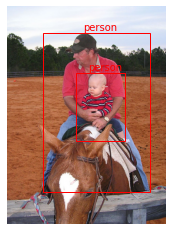

In [42]:
interface.display_img(random.randint(0, len(interface)))